В данной работе необходимо предсказать общий обьем продаж для каждого товара и магазина в следующем месяце на основе данных временных рядов. Алгоритм для построения регрессионной модели является таким же, как и для первой лабораторной работы.

Для начала импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
cats = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test  = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')

In [3]:
items.head(10)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [4]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [5]:
cats.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [6]:
train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [7]:
test.head(10)

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
5,5,5039
6,5,5041
7,5,5046
8,5,5319


Рассмотрим данные, они включают следующие признаки: даты проданного товара, номер месяца, номер товаров и магазинов, номер представляющий пару магазин - товар, номер категории товара, количество проданных товаров, цена товара, наименование товара, наименование магазина, наименование категории товара. Так как пропущенных данных нету, рассмотрим их значения на графиках.

<AxesSubplot:xlabel='item_cnt_day'>

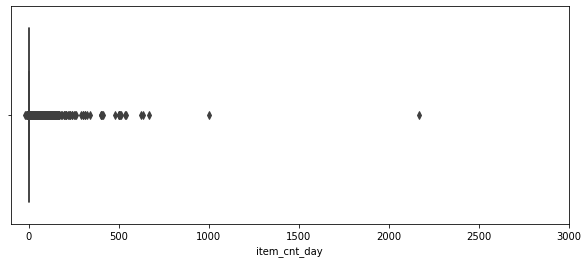

In [8]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

<AxesSubplot:xlabel='item_price'>

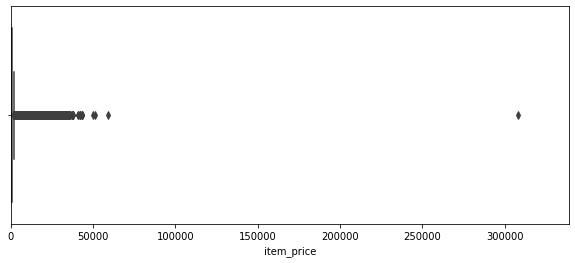

In [9]:
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

На графиках видны 2 сильно выделяющихся значения, для большего качества удалим их из общего количества

In [10]:
train = train[train.item_price<90000]
train = train[train.item_cnt_day<1001]

Также заменим значение признака цена товара, который меньше нуля на среднее значение цены

In [11]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Исправим повторения в признаках названий магазинов заменив их номера

In [12]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Для удобства данных приведем их строковые признаки к числовым. Заменим названия магазинов, на код города, в котором они располагаются, также разделим название категории товара на 2 категории и обе занесем в виде численных значений кодов соответствующих наименований категорий и подкатегорий товара.

In [13]:
#разделение проводим с помощью функции split
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# для случая если признак состоит только из 1 серии(содержит в себе 1 часть изначально)
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [14]:
shops.head(10)

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4
7,7,4
8,8,4
9,9,5


In [15]:
cats.head(10)

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13
5,5,1,14
6,6,1,16
7,7,1,17
8,8,2,26
9,9,3,33


In [16]:
test.describe(include="all")

,shop_id,item_id
count,214200.000000,214200.000000
mean,31.666667,11019.398627
std,17.533229,6252.644590
min,2.000000,30.000000
25%,16.000000,5381.500000
50%,34.500000,11203.000000
75%,47.000000,16071.500000
max,59.000000,22167.000000


С помощью функции intersection, найдем пересечение множеств (общие идентификаторы товара) для обучающей и тестовой выборок, при вычитании длинны тестовой из общего множества двух выборок найдем количество новых товаров тестовой выборки по сравнению с обучающей выборкой

In [17]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

Отсюда видно, что в наборе тестовых данных содержится 214200 значений Магазин-товар, а также 363 новых товара, значит для большинства элементов тестового набора данных целевое значение должно быть равно нулю. А обучающая выборка содержит пары, которые были проданы или возвращены. Из этого следует, что хорошим решением будет подсчитать ежемесячные продажи, а также добавить в них продажи для каждой пары в течение месяца, значения которых равны нулю. Тогда данные обучающей выборки будут аналогичны данным тестовой.

In [18]:
#добавляем в матрицу matrix признаки: номер магазина и товара по номерам месяцев
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
#преобразуем значения матрицы к значениям int    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

создадим в обучающей выборке новый признак, как произведение количества проданных товаров и их цену, чтобы рассчитать значение выручки, затем выделим значения в диапазоне(0, 20). Таким образом мы сделаем обучающую целевую величину наиболее близкой к тестовому предсказанию.

In [19]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [20]:
#вычисляем сумму количества проданных товаров в день(или находим количество проданных товаров в месяц) и присваиваем в данные matrix
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

Также добавим значения из тестовой выборки в матрицу

In [21]:
#приведем данные к типу int
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [22]:
#с помощью функции concat сцепляем матрицы по столбцам
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 месяца

In [23]:
#Добавляем признаки номера магазина, товара, номера категории товара с помощью функции merge, также приводим признаки к типу int
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [24]:
#Вводим функцию, для нахождения количества проданных товаров за n месяцев
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [25]:
#добавим признаки количества товаров проданных за 1,2,3,6 и 12 месяцев
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [26]:
#Добавим признак среднего количества проданных товаров в месяц
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [27]:
#Добавим признак среднего количества проданных товаров за 1,2,3,6 и 12 месяцев
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [28]:
#Добавим признак среднего количества проданных товаров для каждого магазина в n месяцев
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [29]:
#Добавим признак среднего количества проданных товаров для каждого номера категории за 1 месяц
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [30]:
#Добавим признак среднего количества проданных товаров от номера категории для каждого магазина за 1 месяц
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [31]:
#Добавим признак среднего количества проданных товаров для каждого города за 1 месяц
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [32]:
#Добавим признак среднего количества проданных товаров каждого типа категории за 1 месяц
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [33]:
#Добавим признак среднего количества проданных товаров каждого подтипа категории за 1 месяц
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

Рассчитаем изменения цен за последние 6 месяцев

In [34]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

Добавим признак динамики выручки магазина в последнем месяце как разность между выручкой магазина и средней выручкой, деленную на среднюю выручку

In [35]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

Добавим количество месяцев в признаки

In [36]:
matrix['month'] = matrix['date_block_num'] % 12

Добавим признак количества месяцев после старта продаж для пары магазин-товар и для номера товара отдельно

In [37]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

Так как мы уже нашли отдельно все признаки с зависимостями количества месяцев меньше 12, можно удалить эти значения из признака номера месяца

In [38]:
matrix = matrix[matrix.date_block_num > 11]

Также заполним все пустые значения в признаках рассчитаных в определенное количество месяцев n

In [39]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

Занесем все данные в отдельную таблицу pickle для удобства, удалим ненужные данные, файл test оставим для получения выходного файла отправки

In [40]:
matrix.to_pickle('data.pkl')
del matrix
del group
del items
del shops
del cats
del train

In [41]:
data = pd.read_pickle('data.pkl')

Занесем все признаки, которые будут рассматриваться в переменную data

In [42]:
data = data[[ 'date_block_num','shop_id','item_id','item_cnt_month','city_code','item_category_id','type_code','subtype_code','item_cnt_month_lag_1','item_cnt_month_lag_2',
    'item_cnt_month_lag_3','item_cnt_month_lag_6','item_cnt_month_lag_12','date_avg_item_cnt_lag_1','date_item_avg_item_cnt_lag_1','date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3','date_item_avg_item_cnt_lag_6','date_item_avg_item_cnt_lag_12','date_shop_avg_item_cnt_lag_1','date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3','date_shop_avg_item_cnt_lag_6','date_shop_avg_item_cnt_lag_12','date_cat_avg_item_cnt_lag_1','month','item_shop_first_sale',
    'item_first_sale','delta_price_lag']]

Для проверки тестовой выборки необходимо все 34 месяца, для самого набора данных проверок небходимо 33 месяца, для набора обучающих данных можно использовать от 0,3 величины данных, то есть 12-33 месяцев. Разбиваем данные на обучающий и тестовый набор, также удаляем целевой признак из X_train, X_valid и X_test. Обучающий набор будет использоваться для создания модели XGBoost, а тестовый набор будет использоваться, для того, чтобы сделать прогнозы, по которым мы можем оценить качество модели.

In [43]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [44]:
del data
gc.collect();

С помощью библиотеки xgboost построим модель линейной регрессии, которая использует метрику RMSE (квадратный корень из MSE метрики или среднеквадратичной ошибки), которая берет квадратный корень из усредненного отклонения от истинных значений в квадрате. Построим модель для обучающего и тестового набора и проведем мониторинг тестов эффективности для каждого набора.

In [45]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:1.07970	validation_1-rmse:1.06928
[1]	validation_0-rmse:0.98316	validation_1-rmse:0.99354
[2]	validation_0-rmse:0.91990	validation_1-rmse:0.95466
[3]	validation_0-rmse:0.88438	validation_1-rmse:0.93237
[4]	validation_0-rmse:0.86435	validation_1-rmse:0.92308
[5]	validation_0-rmse:0.85318	validation_1-rmse:0.91857
[6]	validation_0-rmse:0.84658	validation_1-rmse:0.91674
[7]	validation_0-rmse:0.83977	validation_1-rmse:0.91820
[8]	validation_0-rmse:0.83588	validation_1-rmse:0.91810
[9]	validation_0-rmse:0.83337	validation_1-rmse:0.91923
[10]	validation_0-rmse:0.83026	validation_1-rmse:0.91927
[11]	validation_0-rmse:0.82823	validation_1-rmse:0.91873
[12]	validation_0-rmse:0.82637	validation_1-rmse:0.91874
[13]	validation_0-rmse:0.82502	validation_1-rmse:0.91815
[14]	validation_0-rmse:0.82403	validation_1-rmse:0.91886
[15]	validation_0-rmse:0.82276	validation_1-rmse:0.92065
[16]	validation_0-rmse:0.82178	validation_1-rmse:0.92038


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

Делаем прогноз на основе модели для заданного диапазона из условия.

In [46]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

#Создаем таблицу для сохранения в виде выходного файла данных
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})

На основе модели построим зависимость важности признаков (каждый признак отображен с его весом в модели)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

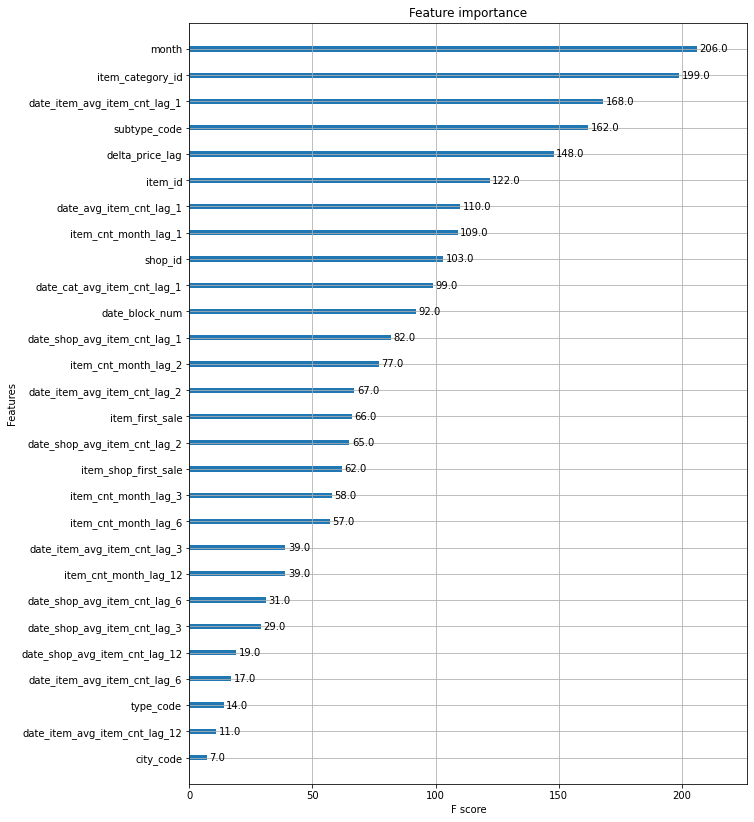

In [47]:
plot_features(model, (10,14))

Отсюда основными весовыми признаками являются: номер категории товара, название подтипа товара, месяц, номер товара, количество товаров проданных за 1 месяц и среднее количество проданных товаров за 1 месяц.

Сохраняем выходной файл прогноза в формате csv

In [48]:
submission.to_csv('xgb_submission.csv', index=False)
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))